# Projet numérique :
## Maxime Carenso et Thomas Foliard

In [1]:
import autograd
from autograd import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Les fonctions bien pratiques : 

- distance permet de calculer les distances entre deux points a et b

- perpendicular renvoie une normale à un vecteur (direction arbitraire)

In [2]:
def distance(a, b) :
    return ((a[0] - b[0])**2 + (a[1]-b[1])**2 ) ** 0.5

def perpendicular( a ) :
    b = np.array([-a[1], a[0]])
    return b

- ici les fonctions gradient et Jacobienne, recopiées directement du poly

In [3]:
def grad_f(f,x,y) :
    g = autograd.grad
    return np.r_[g(f, 0)(x, y), g(f, 1)(x, y)]

def Jacob(F, x, y) :
    j = autograd.jacobian
    return np.c_[j(F, 0)(x, y), j(F, 1)(x, y)]

# Fonction find_seed :
On considère que la fonction étudiée est continue, et on suppose que les cellules choisies sont assez petites pour que :
c soit compris entre f(0, 0) et f(0,1).

Sous cette conditiion, le **théorème des valeurs intermédiaires** nous garantit l'existence d'une solution à f(0, t) = c.

In [4]:
def find_seed(g, c=0, eps = 2**(-26)) :
    # On cherche le réel t tq f(0,t) = c par dichotomie
    a = 0
    b = 1
    if (g(0) < c and g(1) < c) or (g(0) > c and g(1) > c) :
        return None
    while b-a > 2*eps :
        t = (b+a) / 2
        if g(t) > c :
            b = t
        elif g(t) < c :
            a = t
        elif g(t) == c :
            return t
    return (b+a) / 2

# Fonction simple_contour :

### **Fonctionnement :**
- On trouve d'abord un point de la ligne de niveau situé sur la bordure droite de la cellule

- Ensuite, on trouve une première approximation du point suivant en se déplaçant d'un vecteur de norme delta, colinéaire à un vecteur tangent à la courbe (elle-même perpendiculaire au gradient de la fonction en ce point). Il faut simplement faire attention à se déplacer dans le bon sens, ie à ne pas rebrousser chemin.

- Cette méthode seule a une propagation d'erreur trop importante, donc on se rapproche plus du point exact en appliquant la **méthode de Newton** à la fonction F de R² dans R² qui lorsqu'elle s'annule : 
    - vérifie avec sa première coordonnée que le point est bien sur la ligne de niveau **f(x,y) = c**
    - s'assure que le nouveau point créé **b est à la distance delta du point précédent de la ligne de niveau, a**
    
On utilise également la fonction fin_ligne afin d'arrêter le tracé lorsque :
- On arrive au bord de la cellule
- On reboucle sur soi-même

### **Limites / hypothèses :**

- **On ne peut pas définir la tangente lorsque le gradient est nul**, et même si cela n'arrive pas exactement, les erreurs numériques peuvent jouer un rôle prépondérant dans la détermination de sa direction : on évitera les tracés passant par des points critiques.

- Par conséquent on suppose que les lignes de niveau sont **de simples boucles**, car des tracés comme celui-ci impliquerait un point critique au point d'intersection :
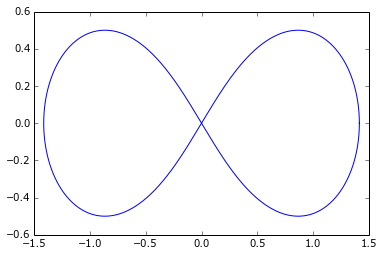

In [5]:
def contrainte(a,b,delta):
    return distance(a,b) - delta

def F(a, b, c, delta, f):
    return np.array([[f(b[0],b[1])-c],[contrainte(a, b, delta)]])

def Newton(f, newton0, dernier, c, delta, eps = 2**(-26)) :
    newton_k = newton0
    Fk = F(newton_k, dernier, c, delta, f)
    while Fk[0] > eps and Fk[1] > eps :
        J_inv = np.linalg.inv(Jacob(F, newton_k[0], newton_k[1]))
        newton_k = newton_k - np.dot(J_inv, F(newton_k, dernier, c, delta, f))
    return newton_k
                
def fin_ligne(X, Y, delta) :
    if X[-1] > 1 - delta/10 or X[-1] < delta/10 or Y[-1] > 1 - delta/10 or Y[-1] < delta/10 :
        return True
    if distance([X[0], Y[0]], [X[-1], Y[-1]]) < delta/2 :
        return True
    return False

**NB :** cette fonction fin_ligne pourrait être problématique si la courbe commence "presque tangente" à la bordure de la cellule, ou si f n'est pas définie en dehors

In [6]:
def simple_contour(f, c=0.0, delta=0.001, eps = 2**(-26)) :

    def g(y) :
        return f(0, y)

    if find_seed(g, c) == None :
        return [], []

    X = [0.0] 
    Y = [find_seed(g, c)]                       # ici le premier point de la ligne de niveau est construit grâce à la dichotomie
    
    perp = perpendicular(grad_f(f, X[0], Y[0])) # on construit la perpendiculaire au gradient calculé en ce premier point
   
    tg = (perp / np.linalg.norm(perp)) * delta  # la norme du gradient (et donc de la perpendiculaire) étant arbitraire,
                                                # il fallait la normer, puis la multiplier par delta
     
    
    if tg[0] >= 0 :                             # ce test permet de vérifier que la tangente part bien vers la droite
        X.append(X[0] + tg[0])
        Y.append(Y[0] + tg[1])
    else :
        X.append(X[0] - tg[0])                  # si ce n'est pas le cas il suffit d'utiliser l'opposé de notre tangeante.
        Y.append(Y[0] - tg[1])

    while not fin_ligne(X, Y, delta) :
        gradient = grad_f(f, X[-1], Y[-1])
        perp = perpendicular(gradient)
        tg = (perp / np.linalg.norm(perp)) * delta
        adernier = [X[-2], Y[-2]]
        dernier = [X[-1],Y[-1]]
        
        if distance(adernier, dernier + tg) >= distance(adernier, dernier - tg) : 
            newton0 = dernier + tg                                                      
        else :
            newton0 = dernier - tg
        
        # On a pris le point le plus loin de l'avant-dernier entre les 2 générés par le vecteur tangent afin d'être sûr
        # de s'être déplacé dans la bonne direction (cela sous-entend que la pas delta est assez petit pour gérer les
        # changments brusques de direction...)
        
        suivant = Newton(f, newton0, dernier, c, delta, eps)
        X.append(suivant[0])
        Y.append(suivant[1])
    
    return X, Y
    # Il reste alors à plotter la ligne de niveau

In [7]:
def f(x, y) : # Fonction du poly
    return 2 * (np.exp(-x**2 - y**2) - np.exp(-(x-1)**2 - (y-1)**2))

# Test de la fonction simple_contour :
Si la fonction marche, alors le test devrait nous donner un arc de cercle de rayon 0.8.

**Erreurs rencontrées (et corrigées) grâce à ce test :**
- La fonction ne renvoyait que 2 points et s'arrêtait aussitôt : oubli de rendre le vecteur tangent de norme delta : on sort tout de suit du cadre
- Erreurs de syntaxe et de typage : la fonction gradient n'aime pas les entiers, on a donc initalisé X avec [0.0] plutôt que [0]

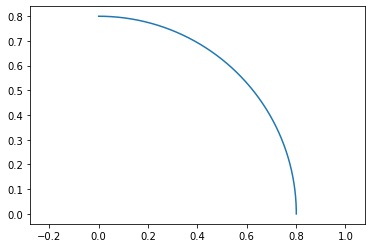

In [8]:
def test_simple(x,y) :
    return x**2 + y**2

les_x, les_y = simple_contour(test_simple, c = 0.64, delta = 0.001)
#print(les_x, les_y)
plt.axis('equal')
plt.plot(les_x, les_y)

## Fonction contour :

Celle du professeur.

<function matplotlib.pyplot.show(*args, **kw)>

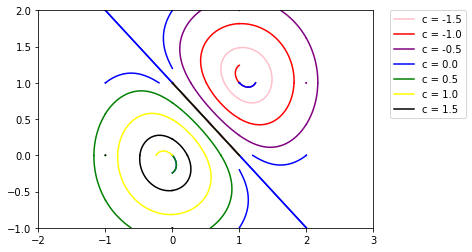

In [12]:
# Rotators
# ------------------------------------------------------------------------------
LEFT, UP, RIGHT, DOWN = 0, 1, 2, 3  # clockwise


def rotate_direction(direction, n=1):
    return (direction + n) % 4


def rotate(x, y, n=1):
    if n == 0:
        return x, y
    elif n >= 1:
        return rotate(1 - y, x, n - 1)
    else:
        assert n < 0
        return rotate(x, y, n=-3 * n)


def rotate_function(f, n=1):
    def rotated_function(x, y):
        xr, yr = rotate(x, y, -n)
        return f(xr, yr)

    return rotated_function


# Complex Contouring
# ------------------------------------------------------------------------------

# Customize the simple_contour function used in contour :
# simple_contour = smart_simple_contour


def contour(f, c, xs=[-2.0,-1.0,0.0, 1.0, 2.0, 3.0], ys=[-1.0,0.0, 1.0, 2.0], delta=0.001):
    curves = []
    nx, ny = len(xs), len(ys)
    for i in range(nx - 1):
        for j in range(ny - 1):
            xmin, xmax = xs[i], xs[i + 1]
            ymin, ymax = ys[j], ys[j + 1]

            def f_cell(x, y):
                return f(xmin + (xmax - xmin) * x, ymin + (ymax - ymin) * y)

            done = set()
            for n in [0, 1, 2, 3]:
                if n not in done:
                    rotated_f_cell = rotate_function(f_cell, n)
                    x_curve_r, y_curve_r = simple_contour(rotated_f_cell, c, delta)
                    exit = None
                    if len(x_curve_r) >= 1:
                        xf, yf = x_curve_r[-1], y_curve_r[-1]
                        if xf == 0 :
                            exit = LEFT
                        elif xf == 1 :
                            exit = RIGHT
                        elif yf == 0 :
                            exit = DOWN
                        elif yf == 1 :
                            exit = UP
                    if exit is not None:  # a fully successful contour fragment
                        exit = rotate_direction(exit, n)
                        done.add(exit)

                    x_curve, y_curve = [], []
                    for x_r, y_r in zip(x_curve_r, y_curve_r):
                        x, y = rotate(x_r, y_r, n=-n)
                        x_curve.append(x)
                        y_curve.append(y)
                    x_curve = np.array(x_curve)
                    y_curve = np.array(y_curve)
                    curves.append(
                        (xmin + (xmax - xmin) * x_curve, ymin + (ymax - ymin) * y_curve)
                    )
    return curves
colors = ['pink','red','purple','blue','green','yellow','black']
for k in range(1,8):

    level_curves=contour(f, (k-4)/2)
    
    i = 0
    for x, y in level_curves:
        if i == 0 :
            plt.plot(x, y, c=colors[k-1], label = f"c = {(k-4)/2}")
            i += 1
        else : 
            plt.plot(x, y, c=colors[k-1])
            i += 1
            
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)   
plt.axis([-2,3,-1,2])
plt.show


# Problème Rencontré :

Des lignes supplémentaires, non désirées apparaissent (parfois seulement un point). 
Nous avons remarqué que ces lignes ont toujours une extrémité dans le coin d'une cellule :

Par exemple, les courbes parasites à l'intérieur des vraies lignes de niveau ont une extrémité en (0,0) ou (1, 1). On a deux points supplémentaires en (-1, 0) et en (2, 1), et la ligne droite entre (1,0) et (0, 1) est couverte par toutes les lignes de niveau...

**Hypothèse :** le problème peut venir du find_seed qui ne trouverait pas de solution et divergerait vers une des bornes de son intervalle

Malheureusement, la condition imposée est censée garantir l'existence d'une racine, la fonction utilisée étant continue.

Ayant testé plusieurs syntaxes de find_seed, nous avons pensé que le problème pourrait provenir de la différence entre la condition de sortie de contour_simple **(être suffisamment proche ou au delà de la bordure)** et les tests de sortie de contour **(dernier point exactement sur la bordure)**, mais adapter fin_ligne / contour_simple pour avoir un point exactement sur la bordure n'a pas fonctionné, et assouplir la condition de contour a mené à la disparition d'une partie de la ligne bleue (car passant par un coin, si on élargit la condition la fonction se "trompe" de côté de sortie.